# Computer generation of fruit shapes from DNA sequence: Ellipses

### Citation:
M. Pérez-Enciso, C. Pons, A. Graell, A.J. Monforte, L.M. Zingaretti. Computer generation of fruit shapes from DNA sequence. Biorxiv. [submitted](https://www.biorxiv.org/content/10.1101/2022.09.19.508595v1)

mperezenciso@gmail.com

### Contents
- Generates 2D and 3D ellipses
- Generates cucurbit shapes
- Generates tomato shapes
- Generates 'offspring' ellipses from 'parents' ellipses
- Generates 'offspring' tomato shapes from 'parents' shapes

### Some relevant sites / documentation used
- https://docs.opencv.org/master/d6/d00/tutorial_py_root.html
- https://scikit-image.org/
- https://github.com/lauzingaretti/DeepAFS 
- https://machinelearningmastery.com/
- https://machinelearningmastery.com/deep-learning-for-computer-vision/
- Geron A. 2019. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
- Chollet F. 2017. https://www.manning.com/books/deep-learning-with-python , p122 ff for CNNs
- https://github.com/Horea94


### relevant image libraries are
- skimage: basic
- opencv: advanced, classical library 
- PIL: basic operations, saving, rotating; 
- https://pillow.readthedocs.io/en/stable/handbook/index.html
- !pip install random2
- !pip install stats


### Modules required

In [1]:
# check library version numbers 
import numpy as np
print('numpy: %s' % np.__version__) 
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import random
import seaborn as sns
import skimage
import scipy
import plotly
import PIL
from PIL import Image, ImageDraw, ImageFilter
import cv2
print('opencv: %s' % cv2.__version__)
print('PIL: %s' % PIL.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

numpy: 1.22.4
matplotlib: 3.4.3
opencv: 4.5.1
PIL: 8.3.2


In [2]:
# DL modules
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
from tensorflow.keras import layers
import kerastuner as kt
print('kerastuner: %s' % kt.__version__)
from tensorflow.python.keras import backend as K

tensorflow: 2.4.1
keras: 2.4.0
kerastuner: 1.0.2


## Ellipses

### Some functions

In [3]:
# draw a continuum circle - ellipse with some stochasticity in a squared image of size x size pixels
def draw_shapec(size):
    img = np.zeros((size,size,1), np.uint8)
    center = (size//2,size//2)
    radius = np.random.randint(4,size//2)
    axis = np.random.randint(4,size//2)
    cv2.ellipse(img,center,(axis,radius),0,0,360,1,-1)
    area = np.count_nonzero(img)/(size*size)
    return img, axis/radius, area

In [4]:
# function to generate dna
# this function returns an n_ind x (n_qtl+n_snp) array with causative and random snps
def do_sequence(g, n_qtl, s2e=0.1, n_snp=0, permute=False):
    """ 
    Generates simple snp data
    g: n_ind x n_trait matrix with genotype values for each indiv and trait
    n_qtl: array with qtl for each trait
    n_snp: num non causal snps
    """
    dna = []
    n_ind, n_trait = g.shape
    
    for t in range(n_trait):
        for _ in range(n_qtl[t]):
            a = g[:,t] + np.random.normal(0, s2e, n_ind)
            dna.append(a)
            
    # add neutral snps
    for _ in range(n_snp):
        a = np.random.normal(0, s2e, n_ind)
        dna.append(a)

    dna = np.array(dna)
    
    # shuffle snp order (if permute=True)
    if permute: 
       rng = np.random.default_rng()
       rng.shuffle(dna)
    
    # transpose 
    dna = dna.transpose()
    
    # normalize
    scaler = StandardScaler()
    scaler.fit(dna)
    dna = scaler.transform(dna)
    
    return dna

In [5]:
# decoder network dna --> image: generates images out of snp data
def dna2image(n_snp,image_size):
    input = tf.keras.layers.Input(shape=(n_snp))

    x = tf.keras.layers.Dense(np.prod(image_size), kernel_initializer='he_uniform')(input)
    x = tf.keras.layers.Reshape(image_size+(1,))(x)
    x = tf.keras.layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
 
    output = tf.keras.layers.Conv2DTranspose(1, (5,5), activation='relu', padding='same')(x)

    return tf.keras.Model(input, output)

In [6]:
# function to plot a sample (n=5) of observed vs predicted fruits
def plot_obs_exp(dna, imgs, model, n=5):
    ilist = np.random.randint(0,dna.shape[0], n)
    image_size = imgs.shape[1:3]
    plt.figure(figsize=(15, 15))
    for i,ind in enumerate(ilist):
        ax = plt.subplot(5, 5, 1+i)
        plt.imshow(imgs[ind,])
        plt.title('Observed:'+str(ind))
        plt.axis("off")
    for i,id in enumerate(ilist):
        ax = plt.subplot(5, 5, 6+i)
        g = tf.expand_dims(dna[id,:], 0)
        img = model.predict(g).reshape(image_size)
        plt.imshow(img)
        plt.title('Predicted:'+str(id))
        plt.axis("off")

In [7]:
# some parameters
n_train = 5000
n_test = 200
size = 64
image_size = (size, size)
n_snp0 = 50

In [8]:
# generate a set of continuum circle / ellipse images for training and test
shapes=[]
imgs=[]
areas=[]

for _ in range(n_train+n_test):
    img, shape, area = draw_shapec(size)
    shapes.append(shape)
    imgs.append(img)
    areas.append(area)

imgs_all = np.array(imgs)
shapes_all = np.array(shapes)
areas_all = np.array(areas)

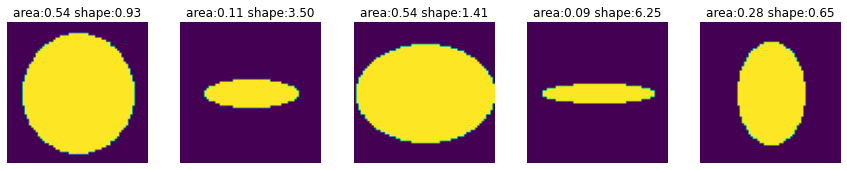

In [9]:
# print first images
plt.figure(figsize=(15, 15))
for i in range(5):
     ax = plt.subplot(5, 5, i + 1)
     plt.imshow(imgs_all[i])
     plt.title('area:%.2f' % areas_all[i] + ' shape:%.2f' % shapes_all[i])
     plt.axis("off")

In [10]:
# add random snps to qtl loci for shape and size
g = np.array([shapes_all, areas_all]).transpose()
dna_all = do_sequence(g,[1,1], s2e=0.01, n_snp=n_snp0, permute=True)
n_snp = dna_all.shape[1]

In [11]:
# split dataset
imgs = imgs_all[:n_train]
dna = dna_all[:n_train]
dna_train, dna_val, imgs_train, imgs_val = train_test_split(dna, imgs, test_size=0.2)
imgs_train.shape

(4000, 64, 64, 1)

In [12]:
# define and fit new decoder
if 'decoder2' in locals() or 'decoder2' in globals(): del decoder2

decoder2 = dna2image(n_snp,image_size)

decoder2.compile(optimizer=keras.optimizers.RMSprop(1.e-3, centered=True),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=tf.keras.metrics.MeanSquaredError(), )

In [13]:
decoder2.fit(x=dna_train,
             y=imgs_train,
             batch_size=16, 
             callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3),], 
             epochs=30,
             validation_data=(dna_val,imgs_val),)

Epoch 1/30
250/250 [==============================] - 23s 88ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - val_loss: 0.0523 - val_mean_squared_error: 0.0523
Epoch 2/30
250/250 [==============================] - 21s 84ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 3/30
250/250 [==============================] - 22s 89ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 4/30
250/250 [==============================] - 18s 72ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5/30
250/250 [==============================] - 16s 63ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 6/30
250/250 [==============================] - 18s 72ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 7/30
250/2

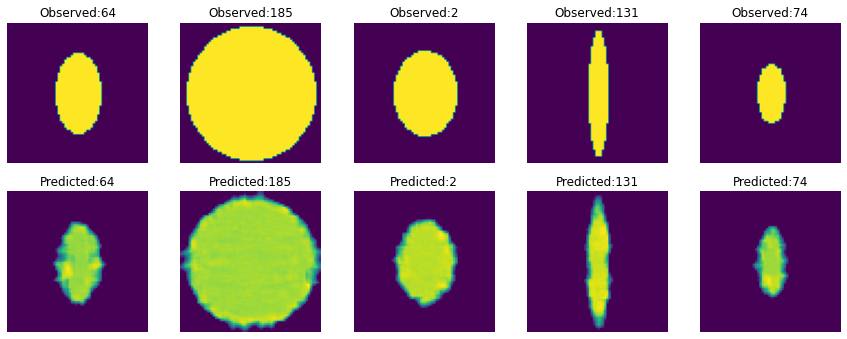

In [16]:
# plot a sample of observed vs predicted ellipses
plot_obs_exp(dna_all[n_train:], imgs_all[n_train:,], decoder2, n=5)

### 3D image prediction

In [20]:
# use pymrt package
# WARNING: this version is not availabale at pip, manually downloaded
import pymrt as mrt
import pymrt.geometry

In [27]:
# plot in 3D
# Marching cubes is an algorithm to extract a 2D surface mesh from a 3D volume. 
from skimage import measure

def draw_3d(img):
    # half slice
    x = int(img.shape[2]/2)
    fig = plt.figure()
    ax1 = fig.add_subplot(141, projection='3d')
    verts, faces, normals, values = measure.marching_cubes(img)
    ax1.plot_trisurf(
        verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap='Spectral',
        antialiased=False, linewidth=2.0)
    ax2 = fig.add_subplot(142)   
    ax2.imshow(img[x,:,:])
    ax3 = fig.add_subplot(143)   
    ax3.imshow(img[:,x,:])
    ax4 = fig.add_subplot(144)   
    ax4.imshow(img[:,:,x])
    plt.show()
    
    surface = skimage.measure.mesh_surface_area(verts, faces)

In [21]:
# draw spheres or ellipses with some stochasticity
def draw_shape3d(size,shape='sphere'):
    img = np.zeros((size,size,1), np.uint8)
    r = np.random.randint(size//4,size//2)
    if shape == 'sphere':
       img = mrt.geometry.ellipsoid(size, (r, r, r))
    else:
       img = mrt.geometry.ellipsoid(size, (r, r/2, r))        
    return img

In [22]:
# generate n random spheres and ellipsoids
size = 32
image_size = (size,size,size)
n_train = 1000
n_test = 100

shapes=[]
imgs=[]
for _ in range(n_train+n_test):
    shape = random.choice(['sphere', 'ellipsoid'])
    shapes.append(shape)
    imgs.append(draw_shape3d(size,shape=shape))

imgs_all = np.array(imgs)
shapes_all = np.array(shapes)
vols_all = imgs_all.sum(axis=(1,2,3))/imgs_all[0].size

# one hot encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(shapes_all)
labels_all = le.transform(shapes)

In [23]:
# 1 use noisy floats of shape and volume as predictors, shape and vol
g = np.array([labels_all, vols_all]).transpose()
scaler = StandardScaler() # scale g
scaler.fit(g)
g = scaler.transform(g)

# generate qtl + neutral snps if selected
dna_all = do_sequence(g, [10,5], n_snp=50,  s2e=0.1, permute=False)
n_snp = dna_all.shape[1] # n_snp=2

# split into train, val and test
imgs = imgs_all[:n_train]
shapes = shapes_all[:n_train]
dna = dna_all[:n_train]

dna_train, dna_val, imgs_train, imgs_val = train_test_split(dna, imgs, test_size=0.2)

In [24]:
# decoder network
def dna2_3dimage(n_snp,image_size):
    input = tf.keras.layers.Input(shape=(n_snp))

    x = tf.keras.layers.Dense(np.prod(image_size))(input)
    x = tf.keras.layers.Reshape(image_size+(1,))(x)
    x = tf.keras.layers.Conv3DTranspose(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv3DTranspose(8, 3, activation='relu', padding='same')(x)
 
    output = tf.keras.layers.Conv3DTranspose(1, 5, activation='relu', padding='same')(x)

    return tf.keras.Model(input, output)

In [25]:
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder = dna2_3dimage(n_snp,image_size)

decoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             2162688   
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 32, 1)     0         
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 32, 32, 32, 16)    448       
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 32, 32, 32, 8)     3464      
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 32, 32, 32, 1)     1001      
Total params: 2,167,601
Trainable params: 2,167,601
Non-trainable params: 0
_________________________________________________

In [26]:
epochs = 10

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder.fit(x=dna_train,
            y=imgs_train,
            batch_size=32, 
            callbacks=callbacks, 
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)


Epoch 1/10
13/13 [==============================] - 25s 2s/step - loss: 0.1025 - mean_squared_error: 0.1025 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 2/10
13/13 [==============================] - 24s 2s/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 3/10
13/13 [==============================] - 25s 2s/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 4/10
13/13 [==============================] - 24s 2s/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5/10
13/13 [==============================] - 24s 2s/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 6/10
13/13 [==============================] - 25s 2s/step - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 7/10
13/13 [======================

*** Shape True_volume Predicted_Volume 
    True and Predicted shapes

sphere 0.28466796875 0.3093802332878113


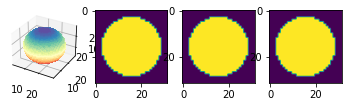

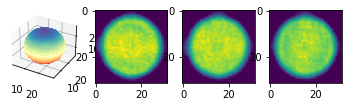

ellipsoid 0.03369140625 0.05444703251123428


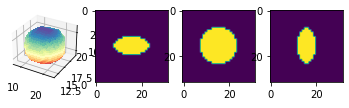

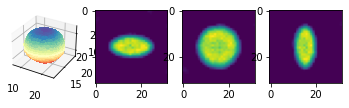

ellipsoid 0.21435546875 0.2511430084705353


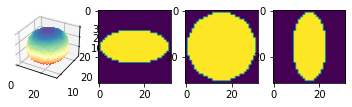

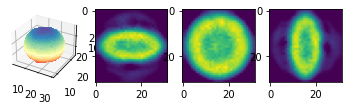

ellipsoid 0.21435546875 0.2210424840450287


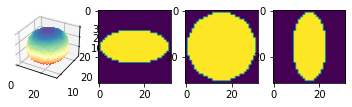

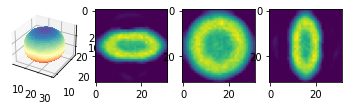

sphere 0.28466796875 0.30933859944343567


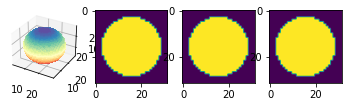

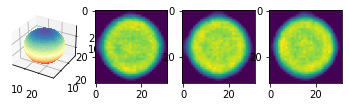

In [28]:
# choose n random dna sequences from unobserved data
print('*** Shape True_volume Predicted_Volume \n    True and Predicted shapes\n')
for _ in range(5):
    i = np.random.randint(n_train,n_train+n_test)
    g = dna_all[i,:]
    g = tf.expand_dims(g, 0)
    ghat = decoder.predict(g).reshape(image_size)
    print(shapes_all[i], vols_all[i], ghat.sum()/ghat.size)
    draw_3d(imgs_all[i])
    draw_3d(ghat)

### Enjoy!